In [1]:
#All imports needed to run the notebook
from metabolinks import align, read_data_csv, read_data_from_xcel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import scaling as sca
%matplotlib inline

This notebook compares the data transformation (missing values imputation, normalization, transformation and scaling) performed by the online software MetaboAnalyst and the methods present in the module scaling of this repository.

The example data used is provided by MetaboAnalyst. The data is available in the statistical analysis section of the software, being the test data labeled as MS Peak List. This data was chosen by being one of the closest to the data that is being used in similarity_analysis being the major difference the "m/z" column since, in this case, it also contains the retention time (due to the data being from LC-MS) and is in the format "mass/retention time". This difference causes a need to work around some things specially on the reading of some files which will be explained when needed.

Note: The files used here were obtained from MetaboAnalyst and ARE NOT present in this repository, therefore running this notebook won't work. The files can be obtained by starting the statistical analysis and picking this file in MetaboAnalyst, do the data processing which will be indicated for each file as they are used in the notebook and getting the .csv file from the download tab of MetaboAnalyst.

### File from MetaboAnalyst reading

The first file is the original file of the data (data_original.csv on the download tab). As such, the methods from scaling will be applied on this data. Here is where the trouble with the index format matters, since the normalization procedure requires a m/z index column (column of floats/integers). To transform this index we do the following:

In [2]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
    final_file.columns = mi
    return final_file

In [3]:
MetAna_O = read_aligned_files('MetAnalyst/MetAna_Original.csv') #data_original.csv (no processing required)

Now, we get and read the files from the other methods. First with missing value imputation (no features removed/features that have more than 100% of missing values removed - reason explained later) by replacing by a half of the minimum value. After this, files with data transformed from all combinations of these 3 methods: normalization by a reference sample (random), glog transformation and Pareto Scaling (if multiple used, they are processed in this order). 

In [4]:
MetAna_I = read_aligned_files('MetAnalyst/MetAna_Imputed.csv') #data_processed.csv (after missing value imputation).

From now on, the files extracted have 2 extra columns (separated m/z and retention time) that aren't required and need to be removed. For that, we apply the following function to the rest of the files:

In [5]:
def reading_MetAna_files(filename):
    file = pd.read_table(filename, header=[0], sep=',')
    file = file.set_index(file.columns[0])
    file.index.name = 'm/z'
    file = file[["ko15","ko16","ko18","ko19","ko21","ko22","wt15","wt16","wt18","wt19","wt21","wt22"]]
    MetAna_file = file.cdf.add_labels(["KO","KO","KO","KO","KO","KO","WT","WT","WT","WT","WT","WT"])
    return MetAna_file

In [6]:
#All of these are obtained from peak_normalized_rt_mz.csv after respective processing. They all have the same missing value
#imputation as above.
#No data filter was performed.
MetAna_P = reading_MetAna_files('MetAnalyst/MetAna_Pareto.csv') #Pareto Scaling only
MetAna_N = reading_MetAna_files('MetAnalyst/MetAna_Norm.csv') #Normalization by a reference feature only - 301/2791.68 (random choice)
MetAna_G = reading_MetAna_files('MetAnalyst/MetAna_Glog.csv') #glog transformation
MetAna_NP = reading_MetAna_files('MetAnalyst/MetAna_np.csv') #normalization by reference feature + Pareto Scaling
MetAna_GP = reading_MetAna_files('MetAnalyst/MetAna_gp.csv') #glog transformation + Pareto Scaling
MetAna_NG = reading_MetAna_files('MetAnalyst/MetAna_ng.csv') #normalization by reference feature + glog transformation
MetAna_NGP = reading_MetAna_files('MetAnalyst/MetAna_ngp.csv') #normalization by reference feature + glog transformation + Pareto Scaling

In [7]:
#Measure distances and linkage matrix of hierarchical clustering for each of the 8 files.
dist_MetAna_I = dist.pdist(MetAna_I.T, metric = 'euclidean')
Z_MetAna_I = hier.linkage(dist_MetAna_I, method='average')
dist_MetAna_P = dist.pdist(MetAna_P.T, metric = 'euclidean')
Z_MetAna_P = hier.linkage(dist_MetAna_P, method='average')
dist_MetAna_N = dist.pdist(MetAna_N.T, metric = 'euclidean')
Z_MetAna_N = hier.linkage(dist_MetAna_N, method='average')
dist_MetAna_G = dist.pdist(MetAna_G.T, metric = 'euclidean')
Z_MetAna_G = hier.linkage(dist_MetAna_G, method='average')
dist_MetAna_NP = dist.pdist(MetAna_NP.T, metric = 'euclidean')
Z_MetAna_NP = hier.linkage(dist_MetAna_NP, method='average')
dist_MetAna_GP = dist.pdist(MetAna_GP.T, metric = 'euclidean')
Z_MetAna_GP = hier.linkage(dist_MetAna_GP, method='average')
dist_MetAna_NG = dist.pdist(MetAna_NG.T, metric = 'euclidean')
Z_MetAna_NG = hier.linkage(dist_MetAna_NG, method='average')
dist_MetAna_NGP = dist.pdist(MetAna_NGP.T, metric = 'euclidean')
Z_MetAna_NGP = hier.linkage(dist_MetAna_NGP, method='average')

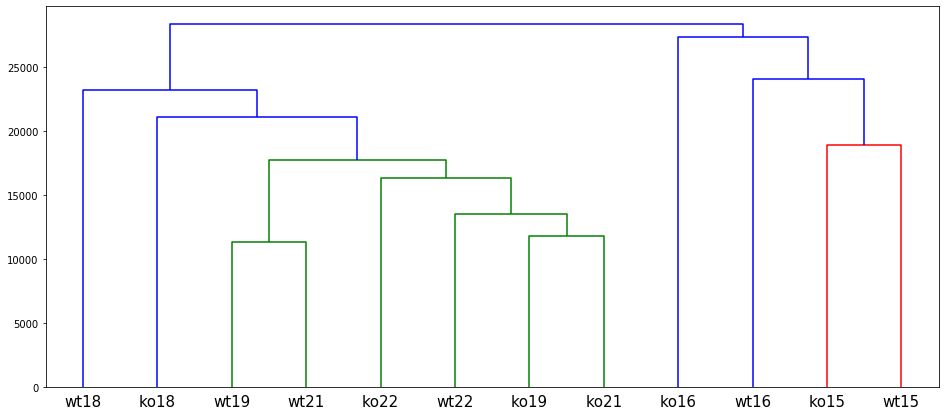

In [8]:
#Example of a dendrogram from this data (Pareto Scaling only)
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_MetAna_P, labels=MetAna_P.cdl.samples,
                     leaf_font_size=15,
                     above_threshold_color='b')

### Applying Scaling module methods to the original data - MetAna_O

In [9]:
#Applying the different methods
I_O = sca.NaN_Imputation(MetAna_O, 0) #Missing Value Imputation (serves as a base to other methods). No features removed.
#Note: This had to be tested without features removed since something in the file seems to give an error when features are
#removed. As far as I can tell, it is because the file, being an LC-MS dataset has some (really rarely) m/z peaks that are the
#same but in different features (due to different retention times). This leads to different rows having the same name which 
#leads to an error in the NaN_Imputation function specifically (since it uses the names of the rows to remove them).


P_O = sca.ParetoScal(I_O) #Pareto Scaling only
N_O = sca.Norm_Feat(I_O, '301/2791.68') #Normalization by a reference feature only - 301/2791.68 (random choice)
G_O = sca.glog(I_O) #glog transformation
NP_O = sca.ParetoScal(N_O) #normalization by reference feature + Pareto Scaling
GP_O = sca.ParetoScal(G_O) #glog transformation + Pareto Scaling
NG_O = sca.glog(N_O) #normalization by reference feature + glog transformation
NGP_O = sca.ParetoScal(NG_O) #normalization by reference feature + glog transformation + Pareto Scaling

In [10]:
#Measure distances and linkage matrix of hierarchical clustering for each of the 8 combinations of methods.
dist_I_O = dist.pdist(I_O.T, metric = 'euclidean')
Z_I_O = hier.linkage(dist_I_O, method='average')
dist_P_O = dist.pdist(P_O.T, metric = 'euclidean')
Z_P_O = hier.linkage(dist_P_O, method='average')
dist_N_O = dist.pdist(N_O.T, metric = 'euclidean')
Z_N_O = hier.linkage(dist_N_O, method='average')
dist_G_O = dist.pdist(G_O.T, metric = 'euclidean')
Z_G_O = hier.linkage(dist_G_O, method='average')
dist_NP_O  = dist.pdist(NP_O.T, metric = 'euclidean')
Z_NP_O = hier.linkage(dist_NP_O, method='average')
dist_GP_O = dist.pdist(GP_O.T, metric = 'euclidean')
Z_GP_O = hier.linkage(dist_GP_O, method='average')
dist_NG_O = dist.pdist(NG_O.T, metric = 'euclidean')
Z_NG_O = hier.linkage(dist_NG_O, method='average')
dist_NGP_O = dist.pdist(NGP_O.T, metric = 'euclidean')
Z_NGP_O = hier.linkage(dist_NGP_O, method='average')

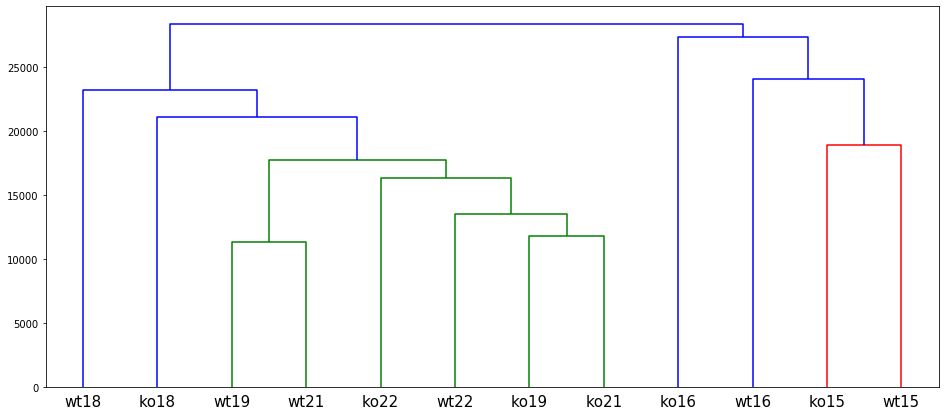

In [11]:
#Example of a dendrogram from this transformed data - same as previous - only Pareto Scaling
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_P_O, labels=P_O.cdl.samples,
                     leaf_font_size=15,
                     above_threshold_color='b')

### Calculating correlation between every combination of data processing from MetaboAnalyst and from scaling

So we repeat the procedure from similarity_analysis.

In [12]:
#We need mergerank from similarity_analysis
def mergerank(Z):
    """Create a 'rank' where each pair of samples has a value equal to the number of the iteration where they started
    being a part of the same cluster (higher value means the samples are farther apart in the dendrogram).
       
       Requires: Z - the return of the linkage function in scypy.stats.hierarchy.
       These values are stored in a (symmetrical) matrix (return of the function).
       Returns: Symmetrical Square Matrix (dimensions: len(Z)+1 by len(Z)+1).
    """
    
    kmatrix = np.zeros((len(Z)+1, len(Z)+1))
    clust = {}
    for i in range(0,len(Z)+1):
        clust[i] = (float(i),)
    for r in range(0,len(Z)):
        if Z[r,0] and Z[r,1] < len(Z)+1:
            kmatrix[int(Z[r,0]),int(Z[r,1])] = r+1
            kmatrix[int(Z[r,1]),int(Z[r,0])] = r+1
            clust[len(Z)+1+r] = Z[r,0],Z[r,1]
        else:
            clust[len(Z)+1+r] = clust[Z[r,0]] + clust[Z[r,1]]
            for i in range(0,len(clust[Z[r,0]])):
                for j in range(0,len(clust[Z[r,1]])):
                    kmatrix[int(clust[Z[r,0]][i]),int(clust[Z[r,1]][j])] = r+1
                    kmatrix[int(clust[Z[r,1]][j]),int(clust[Z[r,0]][i])] = r+1
    return kmatrix


In [13]:
MetAna = (Z_MetAna_I, Z_MetAna_P, Z_MetAna_N, Z_MetAna_G, Z_MetAna_NP, Z_MetAna_GP, Z_MetAna_NG, Z_MetAna_NGP,
            Z_I_O, Z_P_O, Z_N_O, Z_G_O, Z_NP_O, Z_GP_O, Z_NG_O, Z_NGP_O)
dist_MetAna = (dist_MetAna_I, dist_MetAna_P, dist_MetAna_N, dist_MetAna_G, dist_MetAna_NP, dist_MetAna_GP, dist_MetAna_NG,
                  dist_MetAna_NGP, dist_I_O, dist_P_O, dist_N_O, dist_G_O, dist_NP_O, dist_GP_O, dist_NG_O, dist_NGP_O)


K_MetAna = []
S_MetAna = []
Coph_MetAna = []

for i in range(len(MetAna)):
    K_MetAna.append(mergerank(MetAna[i])) #Mergerank
    S_MetAna.append(K_MetAna[i][K_MetAna[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_MetAna.append(hier.cophenet(MetAna[i], dist_MetAna[i])) #Matrix of Cophenetic distances

In [14]:
#Column names and row names for the dataframes
colnames = ['MetAna_I', 'MetAna_P', 'MetAna_N', 'MetAna_G', 'MetAna_NP', 'MetAna_GP', 'MetAna_NG', 'MetAna_NGP',
            'I_O', 'P_O', 'N_O', 'G_O', 'NP_O', 'GP_O', 'NG_O', 'NGP_O']

In [15]:
df_K_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #p-values of K method
df_S_p_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #p-values of S method
df_C_p_MetAna = pd.DataFrame(np.zeros((len(S_MetAna),len(S_MetAna))), columns = colnames, index = colnames) #p-values of C method

In [16]:
#Calculation of correlation coefficient for each method
for i in range(len(S_MetAna)):
    for j in range(len(S_MetAna)):
        df_K_MetAna.iloc[i,j] = stats.kendalltau(S_MetAna[i],S_MetAna[j])[0] #Correlation coefficient
        df_S_MetAna.iloc[i,j] = stats.spearmanr(S_MetAna[i],S_MetAna[j])[0] #Correlation coefficient
        df_C_MetAna.iloc[i,j] = stats.pearsonr(Coph_MetAna[i][1],Coph_MetAna[j][1])[0] #Correlation coefficient
        df_K_p_MetAna.iloc[i,j] = stats.kendalltau(S_MetAna[i],S_MetAna[j])[1] #p-value
        df_S_p_MetAna.iloc[i,j] = stats.spearmanr(S_MetAna[i],S_MetAna[j])[1] #p-value
        df_C_p_MetAna.iloc[i,j] = stats.pearsonr(Coph_MetAna[i][1],Coph_MetAna[j][1])[1] #p-value

And finally we check the results with Heatmaps.

### Heatmaps

Baker (Kendall) Correlation Coefficient Heatmap


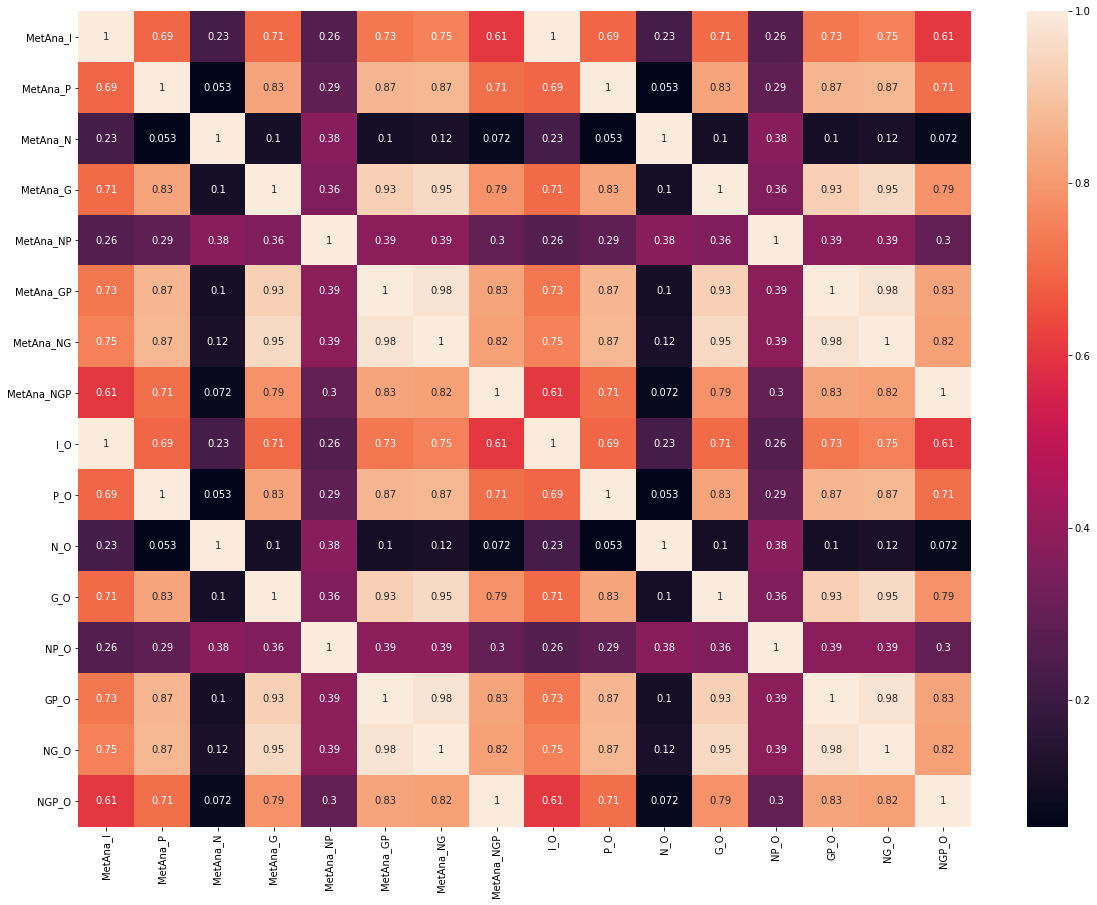

In [17]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap')
hm = sns.heatmap(df_K_MetAna, annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)


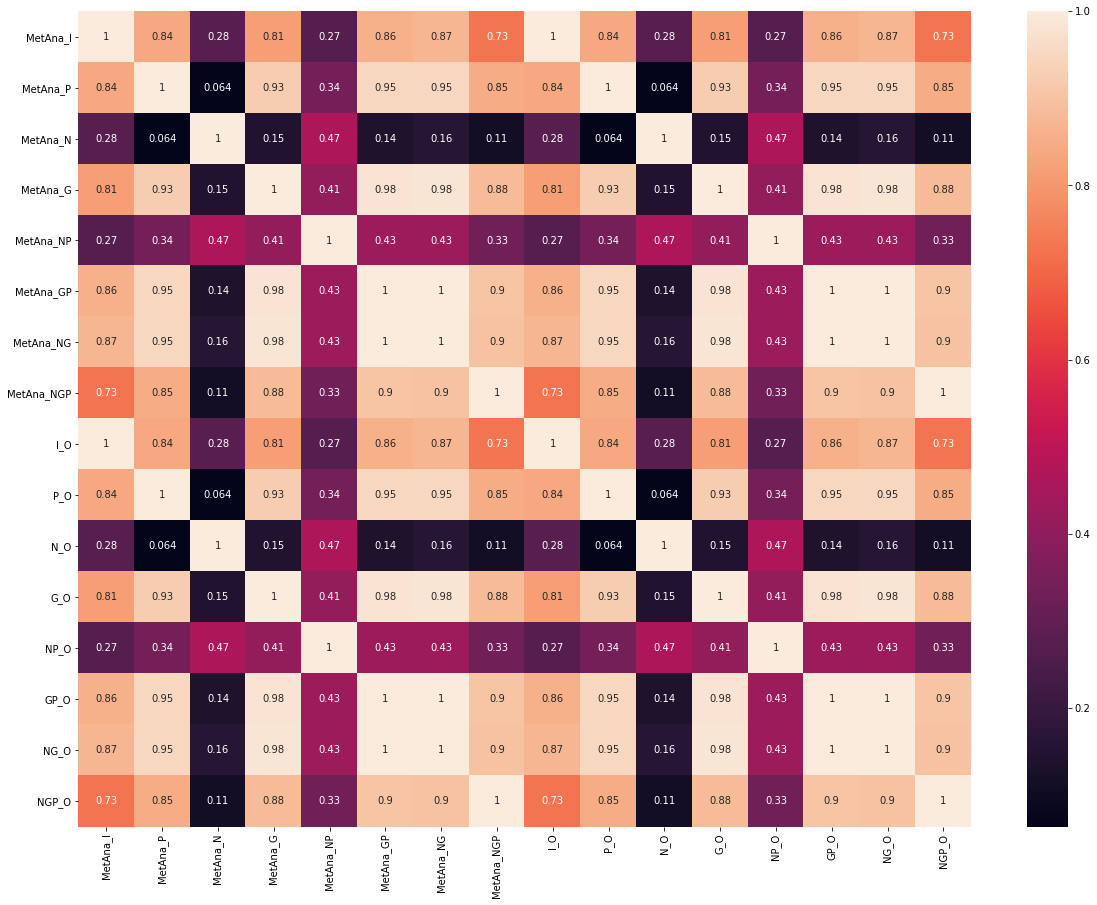

In [18]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
hm = sns.heatmap(df_S_MetAna, annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)


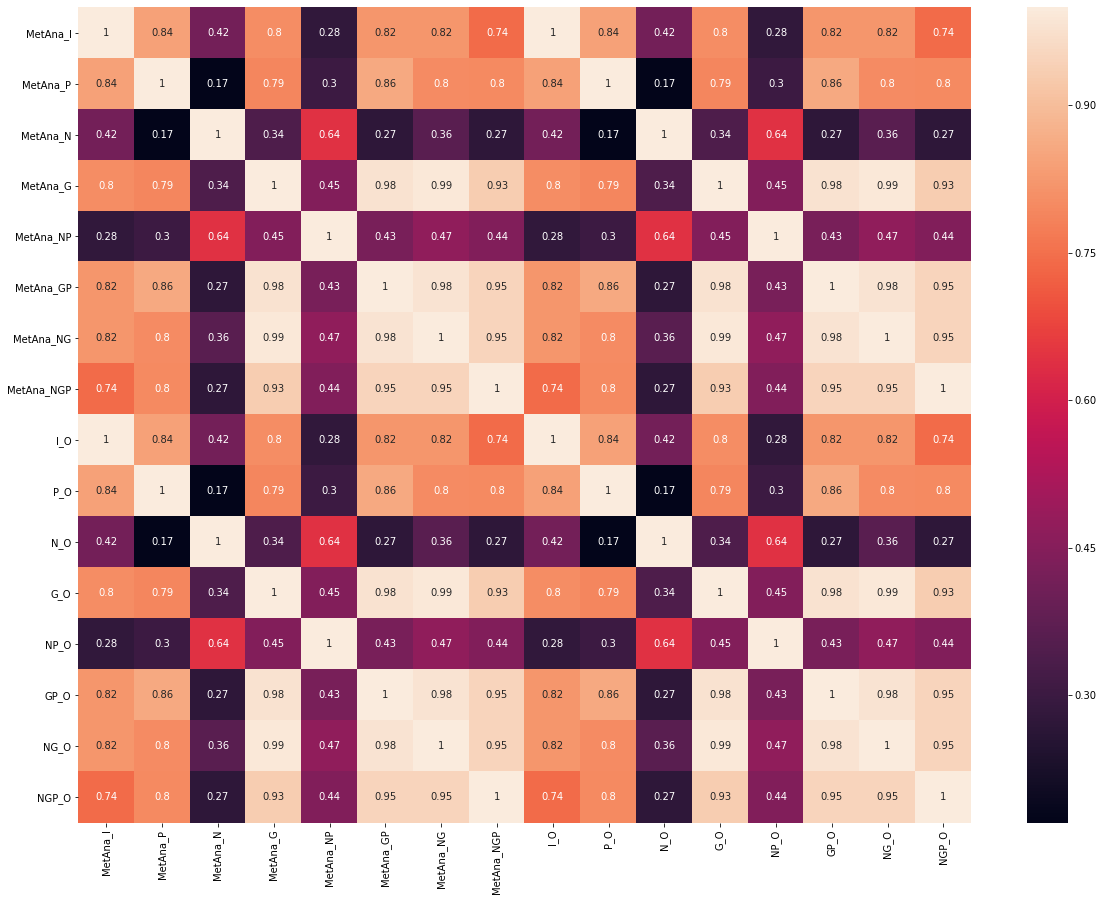

In [19]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
hm = sns.heatmap(df_C_MetAna, annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Results Summary

- The main takeway is the lower diagonal (starting at I_O and MetAna_I and ending in NGP_O and MetAna_NGP) is 1 all across the board. As you can see below, the values aren't all excatly one but are extremely close to it (>0,9999). This means that the analysis of MetaboAnalyst and the scaling module are virtually identical which is a very good sign for the analysis made in similarity_analysis. 
- Howewer there are some other things to consider: first the optimization to calculate lambda in the glog transformation isn't still added in scaling from which we can surmise that it shouldn't make a big effect on the transformation since it already is 0.999997976451 similar to the MetaboAnalyst transformation. It should be this lacking effect that causes the difference observed.
- Furthermore, the glog transformation seems to have a "dominant" effect over the other methods since combinations involving glog transformation (GP, NG, NGP) are always really close to perfect positive correlation (1) to only glog transformation and farther from only normalizatiON or only Pareto Scaling.
- Although normalization seems to have lower correlation with other combinations, we can't conclude that this is due to this method being more transforming of the data or worse since we used a random feature rather than an actual reference feature (like in real datasets) to normalize.
- This analysis allowed the discovering of a mistake while doing Pareto Scaling that has since been fixed (as we can see by the 1 correlation with its counterpart in MetaboAnalyst).
- Despite the high correlation, it's worth noting that the values between the module scaling and MetaboAnalyst aren't exactly equal. For example, the 

In [20]:
print('Cophenetic Correlation Example')
print('Imputation (I) Comparison:                                              \t', df_C_MetAna.iloc[0,8])
print('Pareto Scaling (P) Comparison:                                          \t', df_C_MetAna.iloc[1,9])
print('Normalization (N) Comparison:                                           \t', df_C_MetAna.iloc[2,10])
print('Glog transformation (G) Comparison:                                     \t', df_C_MetAna.iloc[3,11])
print('Normalization + Pareto Scaling (NP) Comparison:                         \t', df_C_MetAna.iloc[4,12])
print('Glog transformation + Pareto Scaling (GP) Comparison:                   \t', df_C_MetAna.iloc[5,13])
print('Normalization + Glog transformation Comparison (NG):                    \t', df_C_MetAna.iloc[6,14])
print('Normalization + Glog transformation + Pareto Scaling (NGP) Comparison : \t', df_C_MetAna.iloc[7,15])

Cophenetic Correlation Example
Imputation (I) Comparison:                                              	 1.0
Pareto Scaling (P) Comparison:                                          	 0.9999999999999999
Normalization (N) Comparison:                                           	 1.0
Glog transformation (G) Comparison:                                     	 0.9999999999999999
Normalization + Pareto Scaling (NP) Comparison:                         	 0.9999999999999999
Glog transformation + Pareto Scaling (GP) Comparison:                   	 1.0
Normalization + Glog transformation Comparison (NG):                    	 1.0
Normalization + Glog transformation + Pareto Scaling (NGP) Comparison : 	 1.0
